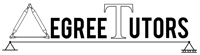
<center>www.DegreeTutors.com</center>

# Bending Moment and Shear Force Calculator
<mark>(For **statically determinate** beams only)</mark>

In [1]:
# DEPENDENCIES and DEFAULTS
import math #........................Math functionality
import numpy as np #.................Numpy for working with arrays

## 1.0 User data input

In [2]:
#DO NOT EDIT - Initialise containers (override below where req'd)
pointLoads = np.array([[]]) #Point Forces [location, xMag, yMag]
pointMoments = np.array([[]]) #Point Moments [location, mag] (clockwise is positive)
distributedLoads = np.array([[]]) #Uniformly distributed loads [xStart, xEnd, yMag]
linearLoads = np.array([[]]) #Distributed loads with linearly varying magnitude [xStart, xEnd, startMag, endMag]

In [3]:
#INPUT SPAN AND FORCE DATA BELOW
span = 17 #Span of beam
A = 3  #Distance to left support
B = 13 #Distance to right support

#Applied force and moment data 
pointLoads = np.array([[6,0,-90]])
pointMoments = np.array([[17,50]])
linearLoads = np.array([[8, 17, -10, 0]])

In [4]:
#Defaults and initialisations
divs = 10000 #Divide span up into this number data points
delta = span/divs #Distance between data points
X = np.arange(0,span + delta,delta) #Range of x-coordinates
nPL = len(pointLoads[0]) #Test for point loads to consider
nPM = len(pointMoments[0]) #Test for uniformly distributed loads to consider
nUDL = len(distributedLoads[0]) #Test for uniformly distributed loads to consider
nLDL = len(linearLoads[0]) #Test for linearly varying magnitude loads to consider


#Initialise data containers
reactions = np.array([0.0,0,0]) #Reactions (Va, Ha, Vb) - Defined as array of floats
shearForce = np.empty([0,len(X)]) #Shear forces at each data point
bendingMoment = np.empty([0,len(X)]) #Bending moment at each data point

<hr>

## 2.0 Reaction Calculation

**2.1 Define a function to calculate reactions due to <u>point loads</u>**

In [5]:
def reactions_PL(n):       
    xp = pointLoads[n,0] #Location of point load
    fx = pointLoads[n,1] #Point load horizontal component magnitude 
    fy = pointLoads[n,2] #Point load vertical component magnitude 
    
    la_p = A-xp  #Lever arm of point load about point A
    mp = fy*la_p #Moment generated by point load about A - closkwise moments are positive
    la_vb = B-A  #Lever arm of vertical reaction at B about point A

    Vb = mp/la_vb #Vertical reaction at B
    Va = -fy-Vb   #Vertical reaction at A    
    Ha = -fx      #Horizontal reaction at A
    
    return Va, Vb, Ha    

**2.2 Define a function to calculate reactions due to <u>point moments</u>**

In [6]:
def reactions_PM(n):       
    xm = pointMoments[n,0] #Location of point moment
    m = pointMoments[n,1]  #Point moment magnitude    
   
    la_vb = B-A #Lever arm of vertical reaction at B about point A

    Vb = m/la_vb #Vertical reaction at B
    Va = -Vb     #Vertical reaction at A    
    
    return Va, Vb

**2.3 Define a function to calculate reactions due to <u>uniformly distributed loads</u> (UDL)**

In [7]:
def reactions_UDL(n): 
    xStart = distributedLoads[n,0] #Location of start of UDL
    xEnd = distributedLoads[n,1]   #Location of end of UDL
    fy = distributedLoads[n,2]     #Magnitude of UDL
    
    fy_Res = fy*(xEnd-xStart)          #Magnitude of resultant 
    x_Res = xStart + 0.5*(xEnd-xStart) #Location of resultant
    
    #SAME AS POINT LOAD FUNCTION FROM HERE 
    la_p = A-x_Res   #Lever arm of resultant load about point A
    mp = fy_Res*la_p #Moment generated by resultant load about A - closkwise moments are positive
    la_vb = B-A      #Lever arm of vertical reaction at B about point A
    
    Vb = mp/la_vb   #Vertical reaction at B
    Va = -fy_Res-Vb #Vertical reaction at A    
    
    return Va, Vb

**2.4 Define a function to calculate reactions due to <u>linearly varying distributed load</u> (LDL)**

In [8]:
def reactions_LDL(n): 
    xStart = linearLoads[n,0]   #Location of start of LDL
    xEnd = linearLoads[n,1]     #Location of end of LDL
    fy_start = linearLoads[n,2] #Magnitude of LDL on left side
    fy_end = linearLoads[n,3]   #Magnitude of LDL on right side
    
    #Determine location and magnitude of force resultant
    if abs(fy_start)>0:
        fy_Res = 0.5*fy_start*(xEnd-xStart)  #Magnitude of resultant 
        x_Res = xStart + (1/3)*(xEnd-xStart) #Location of resultant
    else:
        fy_Res = 0.5*fy_end*(xEnd-xStart) 
        x_Res = xStart + (2/3)*(xEnd-xStart)
        
    
    #SAME AS UDL FUNCTION FROM HERE 
    la_p = A-x_Res   #Lever arm of resultant load about point A
    mp = fy_Res*la_p #Moment generated by resultant load about A - closkwise moments are positive    
    la_vb = B-A      #Lever arm of vertical reaction at B about point A

    Vb = mp/la_vb   #Vertical reaction at B
    Va = -fy_Res-Vb #Vertical reaction at A    
    
    return Va, Vb

**2.5 Cycle through all <u>point loads</u> and determine reactions**

In [9]:
PL_record = np.empty([0,3])
if(nPL>0):
    for n, p in enumerate(pointLoads):
        va, vb, ha = reactions_PL(n) #Calculate reactions
        PL_record = np.append(PL_record, [np.array([va, ha, vb])], axis=0) #Store reactions for each point load

        #Add reactions to record (superposition)
        reactions[0] = reactions[0] + va 
        reactions[1] = reactions[1] + ha 
        reactions[2] = reactions[2] + vb 

**2.6 Cycle through all <u>point moments</u> and determine reactions**

In [10]:
PM_record = np.empty([0,2])
if(nPM>0):
    for n, p in enumerate(pointMoments):
        va, vb = reactions_PM(n) #Calculate reactions
        PM_record = np.append(PM_record, [np.array([va, vb])], axis=0) #Store reactions for each point moment

        #Add reactions to record (superposition)
        reactions[0] = reactions[0] + va 
        reactions[2] = reactions[2] + vb         

**2.7 Cycle through all <u>UDLs</u> and determine reactions**

In [11]:
UDL_record = np.empty([0,2])
if(nUDL>0):
    for n, p in enumerate(distributedLoads):
        va, vb = reactions_UDL(n) #Calculate reactions
        UDL_record = np.append(UDL_record, [np.array([va, vb])], axis=0) #Store reactions for each distributed load

        #Add reactions to record (superposition)
        reactions[0] = reactions[0] + va 
        reactions[2] = reactions[2] + vb 

**2.8 Cycle through all <u>LDLs</u> and determine reactions**

In [12]:
LDL_record = np.empty([0,2])
if(nLDL>0):
    for n, p in enumerate(linearLoads):
        va, vb = reactions_LDL(n) #Calculate reactions
        LDL_record = np.append(LDL_record, [np.array([va, vb])], axis=0) #Store reactions for each linearly distributed load

        #Add reactions to record (superposition)
        reactions[0] = reactions[0] + va 
        reactions[2] = reactions[2] + vb 

<hr>

## 3.0 Shear and Moment Calculation

**3.1 Define function to calculate shear forces and bending moments due to <u>point loads</u>**

In [13]:
def shear_moment_PL(n):    
    xp = pointLoads[n,0] #Location of point load
    fy = pointLoads[n,2] #Point load vertical component magnitude 
    Va = PL_record[n,0]  #Vertical reaction at A for this point load
    Vb = PL_record[n,2]  #Vertical reaction at B for this point load
    
    #Cycle through the structure and calculate the shear force and bending moment at each point
    Shear = np.zeros(len(X))  #Initialise a container to hold all shear force data for this point load
    Moment = np.zeros(len(X)) #Initialise a container to hold all moment force data for this point load
    for i, x in enumerate(X):    
        shear = 0  #Initialise the shear force for this data point
        moment = 0 #Initialise the bending moment for this data point

        if x>A:
            #Calculate shear and moment from reaction at A
            shear = shear + Va
            moment = moment - Va*(x-A)

        if x>B:
            #Calculate shear and moment from reaction at B
            shear = shear + Vb
            moment = moment - Vb*(x-B)

        if x>xp:
            #Calculate shear and moment from point load
            shear = shear + fy
            moment = moment - fy*(x-xp)

        #Store shear and moment for this location
        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

**3.2 Define function to calculate shear forces and bending moments due to <u>point moments</u>**

In [14]:
def shear_moment_PM(n):    
    xm = pointMoments[n,0] #Location of point moment
    m = pointMoments[n,1]  #Point moment magnitude 
    Va = PM_record[n,0]    #Vertical reaction at A for this point moment
    Vb = PM_record[n,1]    #Vertical reaction at B for this point moment
    
    #Cycle through the structure and calculate the shear force and bending moment at each point
    Shear = np.zeros(len(X))  #Initialise a container to hold all shear force data for this point moment
    Moment = np.zeros(len(X)) #Initialise a container to hold all moment force data for this point moment
    for i, x in enumerate(X):    
        shear = 0  #Initialise the shear force for this data point
        moment = 0 #Initialise the bending moment for this data point

        if x>A:
            #Calculate shear and moment from reaction at A
            shear = shear + Va
            moment = moment - Va*(x-A)

        if x>B:
            #Calculate shear and moment from reaction at B
            shear = shear + Vb
            moment = moment - Vb*(x-B)

        if x>xm:
            #Calculate moment due to point moment (No influence on shear)            
            moment = moment - m

        #Store shear and moment for this location
        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

**3.3 Define function to calculate shear forces and bending moments due to <u>UDLs</u>**

In [15]:
def shear_moment_UDL(n):    
    xStart = distributedLoads[n,0] #Location of start of UDL
    xEnd = distributedLoads[n,1]   #Location of end of UDL
    fy = distributedLoads[n,2]     #Magnitude of UDL
    Va = UDL_record[n,0] #Vertical reaction at A for this UDL
    Vb = UDL_record[n,1] #Vertical reaction at B for this UDL
    
    #Cycle through the structure and calculate the shear force and bending moment at each point
    Shear = np.zeros(len(X))  #Initialise a container to hold all shear force data for this UDL
    Moment = np.zeros(len(X)) #Initialise a container to hold all moment force data for this UDL
    for i, x in enumerate(X):    
        shear = 0  #Initialise the shear force for this data point
        moment = 0 #Initialise the bending moment for this data point
                
        if x>A:
            #Calculate shear and moment from reaction at A
            shear = shear + Va
            moment = moment - Va*(x-A)

        if x>B:
            #Calculate shear and moment from reaction at B
            shear = shear + Vb
            moment = moment - Vb*(x-B)
        
        if x>xStart and x<=xEnd:
            #Cut through UDL - calculate shear and moment from UDL
            shear = shear + fy*(x-xStart)
            moment = moment - fy*(x-xStart)*0.5*(x-xStart)
        elif x>xEnd:
            #Cut to right of UDL - calculate shear and moment from UDL
            shear = shear + fy*(xEnd-xStart)
            moment = moment - fy*(xEnd-xStart)*(x - xStart - 0.5*(xEnd-xStart))

        #Store shear and moment for this location
        Shear[i] = shear
        Moment[i] = moment    

    return Shear, Moment                

**3.4 Define function to calculate shear forces and bending moments due to <u>LDLs</u>**

In [16]:
def shear_moment_LDL(n): 
    xStart = linearLoads[n,0]   #Location of start of LDL
    xEnd = linearLoads[n,1]     #Location of end of LDL
    fy_start = linearLoads[n,2] #Magnitude of left side of LDL
    fy_end = linearLoads[n,3]   #Magnitude of right side of LDL
    Va = LDL_record[n,0] #Vertical reaction at A for this LDL
    Vb = LDL_record[n,1] #Vertical reaction at B for this LDL
    
    #Cycle through the structure and calculate the shear force and bending moment at each point
    Shear = np.zeros(len(X))  #Initialise a container to hold all shear force data for this LDL
    Moment = np.zeros(len(X)) #Initialise a container to hold all moment force data for this LDL
    for i, x in enumerate(X):    
        shear = 0  #Initialise the shear force for this data point
        moment = 0 #Initialise the bending moment for this data point
                
        if x>A:
            #Calculate shear and moment from reaction at A
            shear = shear + Va
            moment = moment - Va*(x-A)

        if x>B:
            #Calculate shear and moment from reaction at B
            shear = shear + Vb
            moment = moment - Vb*(x-B)
        
        if x>xStart and x<=xEnd:
            #Cut through LDL - calculate shear and moment from LDL
            if abs(fy_start)>0:
                x_base = x-xStart #Base of the triangular load distribution
                f_cut = fy_start - x_base*(fy_start/(xEnd-xStart)) #Magnitude of LDL at cut
                R1 = 0.5*x_base*(fy_start-f_cut) #Magnitude of resultant for triangular portion of load
                R2 = x_base*f_cut #Magnitude of resultant for constant portion of load 
                shear = shear + R1 + R2
                moment = moment - R1*(2/3)*x_base - R2*(x_base/2)
            else:
                x_base = x-xStart #Base of the triangular load distribution
                f_cut = fy_end*(x_base/(xEnd-xStart)) #Magnitude of LDL at cut
                R = 0.5*x_base*f_cut #Magnitude of resultant
                shear = shear + R
                moment = moment - R*(x_base/3)
                
        elif x>xEnd:
            #Cut to right of LDL - calculate shear and moment from LDL
            if abs(fy_start)>0:
                R = 0.5*fy_start*(xEnd-xStart)
                xr = xStart + (1/3)*(xEnd-xStart)                
                shear = shear + R
                moment = moment - R*(x-xr)
            else:
                R = 0.5*fy_end*(xEnd-xStart)
                xr = xStart + (2/3)*(xEnd-xStart)                
                shear = shear + R
                moment = moment - R*(x-xr)
                

        #Store shear and moment effects for this location
        Shear[i] = shear
        Moment[i] = moment    

    return Shear, Moment                

**3.5 Cycle through all <u>point loads</u> and determine shear and moment**

In [17]:
#Calculate the shear force and bending moment at each datapoint due to point load
if(nPL>0):
    for n, p in enumerate(pointLoads):
        Shear, Moment = shear_moment_PL(n)
        shearForce = np.append(shearForce, [Shear], axis=0)        #Store shear force record for each point load
        bendingMoment = np.append(bendingMoment, [Moment], axis=0) #Store bending moment record for each point load

**3.6 Cycle through all <u>point moments</u> and determine moment**

In [18]:
#Calculate the shear force and bending moment at each datapoint due to point moment
if(nPM>0):
    for n, p in enumerate(pointMoments):
        Shear, Moment = shear_moment_PM(n)
        shearForce = np.append(shearForce, [Shear], axis=0)        #Store shear force record for each point moment
        bendingMoment = np.append(bendingMoment, [Moment], axis=0) #Store bending moment record for each point moment

**3.7 Cycle through all <u>UDLs</u> and determine shear and moment**

In [19]:
#Calculate the shear force and bending moment at each datapoint due to UDL
if(nUDL>0):
    for n, p in enumerate(distributedLoads):
        Shear, Moment = shear_moment_UDL(n)
        shearForce = np.append(shearForce, [Shear], axis=0)        #Store shear force record for each UDL
        bendingMoment = np.append(bendingMoment, [Moment], axis=0) #Store bending moment record for each UDL

**3.8 Cycle through all <u>LDLs</u> and determine shear and moment**

In [20]:
#Calculate the shear force and bending moment at each datapoint due to LDL
if(nLDL>0):
    for n, p in enumerate(linearLoads):
        Shear, Moment = shear_moment_LDL(n)
        shearForce = np.append(shearForce, [Shear], axis=0) #Store shear force record for each LDL
        bendingMoment = np.append(bendingMoment, [Moment], axis=0) #Store bending moment record for each LDL

<hr>

## 4.0 Plotting and Printing

In [21]:
print('The vertical reaction at A is {one} kN'.format(one=round(reactions[0],2)))
print('The vertical reaction at B is {one} kN'.format(one=round(reactions[2],2)))
print('The horizontal reaction at A is {one} kN'.format(one=round(reactions[1],2)))

The vertical reaction at A is 67.0 kN
The vertical reaction at B is 68.0 kN
The horizontal reaction at A is 0.0 kN


**Plotly**
<a href="https://plotly.com/python/">🔗  Plotly reference docs</a>

In [25]:
import plotly as py #Import Plotly 
import plotly.graph_objs as go #Import graph objects
py.offline.init_notebook_mode(connected=True) #Setup offline plotting (inside Jupyter notebook)

In [23]:
#Define the layout object
layout = go.Layout(
    title={
        'text': "Shear Force Diagram",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    titlefont=dict(size=15),
    yaxis = dict(
        title='Shear Force (kN)',
    ),
    xaxis = dict(
        title='Distance (m)',       
        range=[-1, span+1]
    ),
    showlegend=False,        
)

#Define the shear force trace
line = go.Scatter(
    x = X,
    y = sum(shearForce),
    mode='lines',
    name='Shear Force',
    fill='tonexty',
    line_color='green',
    fillcolor='rgba(0, 255, 0, 0.1)'
)

#Define a horizontal line to represent the structure
axis = go.Scatter(
    x = [0, span],
    y = [0,0],
    mode='lines',
    line_color='black'
)

#Generate and view the figure
fig = go.Figure(data=[line, axis], layout=layout)

py.offline.iplot(fig)


In [24]:
#Define the layout object
layout = go.Layout(
    title={
        'text': "Bending Moment Diagram",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    titlefont=dict(size=15),
    yaxis = dict(
        title='Bending Moment (kNm)',
        autorange="reversed"
    ),
    xaxis = dict(
        title='Distance (m)',       
        range=[-1, span+1]
    ),
    showlegend=False 
)

#Define the Bending Moment trace
line = go.Scatter(
    x = X,
    y = -sum(bendingMoment),
    mode='lines',
    name='Bending Moment',
    fill='tonexty',
    line_color='red',
    fillcolor='rgba(255, 0, 0, 0.1)'
)

#Define a horizontal line to represent the structure
axis = go.Scatter(
    x = [0, span],
    y = [0,0],
    mode='lines',
    line_color='black'
)

#Generate and view the figure
fig = go.Figure(data=[line, axis], layout=layout)
py.offline.iplot(fig)
